In [9]:
## Setup
!pip install kaggle
!mkdir ~/.kaggle

In [10]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Linear regression w. scipy.stats

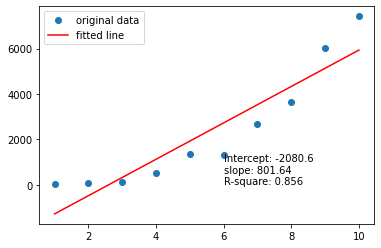

In [3]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

x=np.array([1,2,3,4,5,6,7,8,9,10])
y=np.array([2.3,4.5,5.0,8,11.1,10.9,13.9,15.4,18.2,19.5])
y=y+10

## Linear regression module from scipy.stats
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# Calculated fitted y
y_fit=intercept + (x*gradient)

# Plot data
plt.plot(x, y, 'o', label='original data')
plt.plot(x, y_fit, 'r', label='fitted line')

# Add text box and legend
text='Intercept: %.1f\nslope: %.2f\nR-square: %.3f' %(intercept,gradient,r_value**2)
plt.text(6,15,text)
plt.legend()

plt.show()

## Linear regression w/ multiple lin. reg. (scikit-learn)

In [21]:
## First copy the link and parse the last two sections to get the dataset name
!kaggle datasets download kumarajarshi/life-expectancy-who

  0% 0.00/119k [00:00<?, ?B/s]
100% 119k/119k [00:00<00:00, 42.6MB/s]


In [22]:
!unzip life-expectancy-who.zip

Archive:  life-expectancy-who.zip
  inflating: Life Expectancy Data.csv  


In [23]:
import pandas as pd

filename = 'Life Expectancy Data.csv'
df = pd.read_csv(filename)
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## Distribution fitting to data

In [37]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
# Load data and select first column

from sklearn import datasets
data_set = datasets.load_breast_cancer()
y=data_set.data[:,0]

# Create an index array (x) for data

x = np.arange(len(y))
size = len(y)

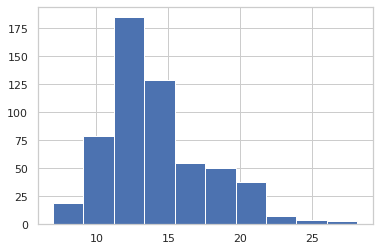

In [38]:
# Visualize data
plt.hist(y)
plt.show()

In [39]:
# Describe data
y_df = pd.DataFrame(y, columns=['Data'])
y_df.describe()

,Data
count,569.000000
mean,14.127292
std,3.524049
min,6.981000
25%,11.700000
50%,13.370000
75%,15.780000
max,28.110000


In [40]:
## Standardize the data
sc=StandardScaler() 
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [41]:
# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     30.426685  0.17957
2        gamma     44.960532  0.06151
5     pearson3     44.961716  0.06152
0         beta     48.102181  0.06558
4         norm    292.430764  0.00000
6       triang    532.742597  0.00000
7      uniform   2150.558410  0.00000
1        expon   5701.446012  0.00000
9  weibull_max  10452.188968  0.00000
8  weibull_min  12002.386769  0.00000


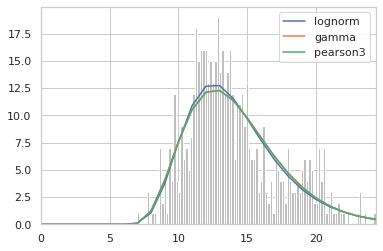


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.3411670333611477, 4.067737189292493, 9.490709944326486)

Distribution: gamma
Parameters: (5.252232022713325, 6.175162625863668, 1.5140473798580563)

Distribution: pearson3
Parameters: (0.8726704680754525, 14.127306804909308, 3.4698385545042782)


In [42]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )


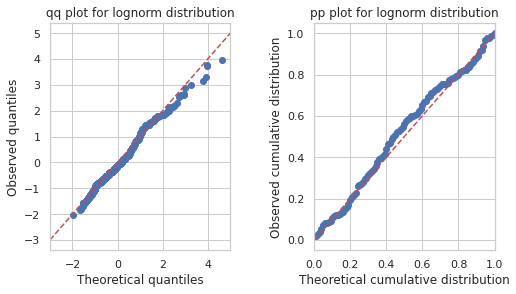

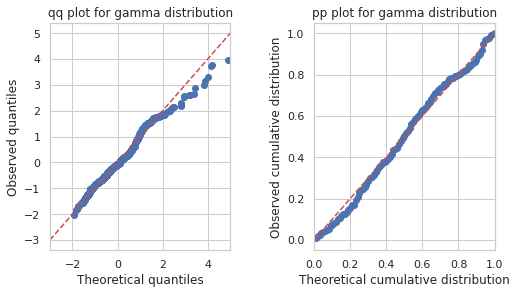

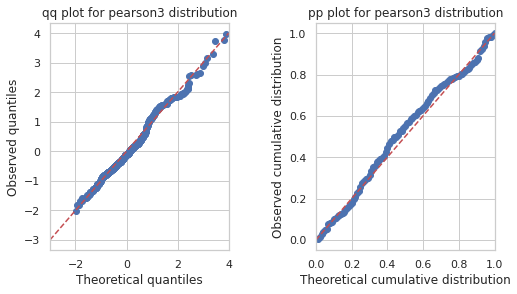

In [43]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()